# LLM в математике и информатике, Сириус 2026
## Занятие 4. Линейная регрессия


## Небольшой теоретический блок: основные понятия в ML

Перед тем как писать код, договоримся о терминах, которые будем использовать.

---

### 1. Данные

В задачах машинного обучения у нас есть **данные** — набор объектов и информация о них.

- **Признаки (features)** — это характеристики объекта.  
  Мы будем обозначать их как  
  $
  x_1, x_2, \dots, x_p
  $
  где $ p $ — количество признаков.

- **Один объект** — это набор значений признаков:  
  $$
  \mathbf{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})
  $$

- **Целевой признак (target)** — это то, что мы хотим предсказать.  
  Обычно обозначается как $ y_i $.

Пример:
- признаки: возраст, пол, регион
- target: стоимость страховки

---

### 2. Что такое модель

**Модель** — это функция, которая по признакам объекта пытается предсказать целевой признак.

Общая идея:
$$
y \approx f(\mathbf{x})
$$

Наша цель — подобрать такую функцию \( f \), чтобы она **хорошо приближала реальную зависимость в данных**.

---

### 3. Параметрические и непараметрические модели

**Параметрические модели**
- имеют фиксированное число параметров
- обучаются подбором этих параметров

Примеры:
- константная модель
- **линейная регрессия**

**Непараметрические модели**
- не имеют явных параметров
- используют сами данные напрямую

Пример:
- kNN (k ближайших соседей)

В этом ноутбуке мы работаем с **параметрической моделью — линейной регрессией**.

---

### 4. Линейная регрессия: идея

Линейная регрессия предполагает, что target зависит от признаков **линейно**.

Общий вид модели:
$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_p x_p
$$

Здесь:
- $ x_1, \dots, x_p $ — признаки объекта
- $ \theta_0 $ — свободный коэффициент (bias)
- $ \theta_1, \dots, \theta_p $ — **коэффициенты модели (веса)**

---

### 5. Что означают коэффициенты

Каждый коэффициент $ \theta_j $ показывает:

> **насколько сильно признак $ x_j $ влияет на target**,  
> если остальные признаки зафиксированы.

Например:
- если $ \theta_2 > 0 $, то увеличение $ x_2 $ обычно увеличивает $ y $
- если $ \theta_2 < 0 $, то увеличение $ x_2 $ уменьшает $ y $

---

### 6. Реальные данные и шум

В реальных данных всегда есть случайность и ошибки измерений, поэтому:

$$
y_i = \theta_0 + \theta_1 x_{i1} + \dots + \theta_p x_{ip} + \varepsilon_i
$$

где:
- $ \varepsilon_i $ — случайный шум (ошибка)

Модель не пытается угадать шум —  
она ищет **лучшую линейную зависимость в среднем**.

---

### 7. Что значит "обучить модель"

**Обучить линейную регрессию** — значит:
- подобрать такие коэффициенты $ \theta_0, \dots, \theta_p $,
- чтобы предсказания $ \hat{y} $ были как можно ближе к реальным значениям $ y $.

На практике это делается автоматически с помощью библиотек (например, `scikit-learn`).

---

💡 В следующих ячейках мы:
- посмотрим на данные,
- построим графики,
- обучим линейную регрессию,
- и разберём, что означают полученные коэффициенты.


В данном ноутбуке мы рассмотрим несложный пример построения модели линейной регрессии, а также предварительной обработки данных. Для построения моделей и методов обработки данных будем использовать широко известную библиотеку <a target="_blank" href="https://scikit-learn.org/">Scikit-Learn</a> (сокращенно `sklearn`), в которой в удобной форме реализованы многие методы машинного обучения и анализа данных в целом. Более того, принятый интерфейс библиотеки часто используют разработчики других библиотек в силу удобства его использования.

Поставить библиотеку можно командой `pip install scikit-learn`.

In [1]:
from typing import Tuple, Optional
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

RANDOM_STATE = 42  # фиксируем seed случайности

pd.options.mode.chained_assignment = None
np.random.seed(RANDOM_STATE)
sns.set(font_scale=1.3, palette="Set2")

### 1. Введение

#### 1.1 Данные

Рассмотрим задачу обучения модели регрессии на искусственных данных, которые генерируются по линейному закону с добавлением случайного шума. Формула, которая описывает зависимость: $y = f(x) + \varepsilon$, где
* $f(x) = 5x_1 - 3x_2 + 4x_3$ — истинная целевая функция.
* $\varepsilon$ — аддитивный шум, следующий нормальному распределению $\varepsilon \sim \mathcal{N}(0, 1)$.


Функция для генерации данных.

In [2]:
def generate_linear_data(
    n_samples: int = 100,
    num_features: int = 10,
    theta_values: Optional[np.ndarray] = None,
    X_max: float = 10.0,
    noise_scale: float = 3.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные: y = X_true * theta_true + ε, где ε ~ N(0, noise_scale).

    Параметры:
    n_samples (int): Количество выборок.
    num_features (int): Общее количество признаков.
    theta_values (Optional[np.ndarray]): Вектор коэффициентов.
    X_max (float): Максимальное значение для генерации features.
    noise_scale (float): Стандартное отклонение шума.

    Возвращает:
    Tuple[np.ndarray, np.ndarray]: Кортеж из двух массивов numpy: features и target_values.
    """
    theta_values = theta_values

    # Признаки: генерация случайных значений от 0 до X_max
    features = np.random.uniform(low=0.0, high=X_max, size=(n_samples, num_features))

    target_values = features @ theta_values.reshape(-1, 1)
    # Генерация шума
    noise = np.random.normal(loc=0.0, scale=noise_scale, size=(n_samples, 1))
    # Добавляем шум
    target_values += noise

    return features, target_values.ravel()

Сгенерируем данные:

In [3]:
n_samples = 200
num_features = 3
X_max = 3
theta_values = np.array([5, -3, 4])
X_grid = np.linspace(0, X_max)

X, y = generate_linear_data(
    n_samples=n_samples, num_features=num_features, theta_values=theta_values, X_max=X_max
)

Посмотрим на среднее значение таргета

In [4]:
means = X.mean(axis=0) # берем среднее значение по каждому признаку
mean_target = np.sum(theta_values * means) 
mean_target

np.float64(8.686006541638184)

#### 1.2 Визуальный анализ
Построим графики зависимости таргета от каждого признака. Нанесем на них данные и истинное значение.

Что такое истинное значение? Здесь мы предполагаем, что признаки друг от друга независимы,
- зафиксируем два признака за своим средним значением по всем данным;
- оставшийся признак будем менять от своего минимально значения до максимального (опять же, по данным). 

При таких предположениях и поскольку мы знаем формулу истинной целевой функции $y = 5x_1 - 3x_2 + 4x_3$, мы можем посчитать истинное значение таргета.

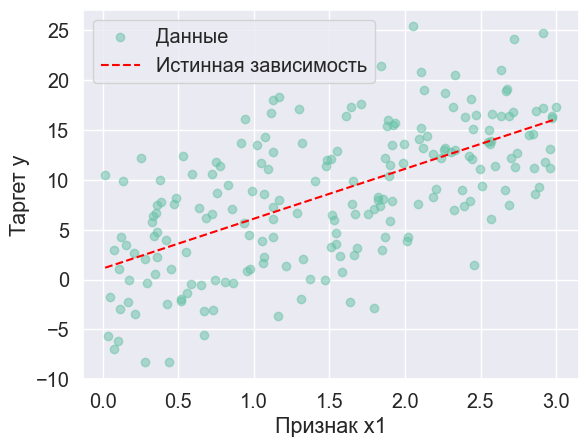

In [5]:
x1 = X[:, 0] 
plt.scatter(x1, y, alpha=0.5, label="Данные")

x1_grid = np.linspace(x1.min(), x1.max(), 100)
# варьируем x1 при фиксированных x2, x3 равных среднему значению
x1_true = x1_grid * theta_values[0] + (mean_target - means[0] * theta_values[0])

plt.plot(x1_grid, x1_true, 'r--', label="Истинная зависимость")
plt.xlabel("Признак x1")
plt.ylabel("Таргет y")
plt.legend()
plt.show()

Можем нарисовать такие же графики для всех трех признаков:

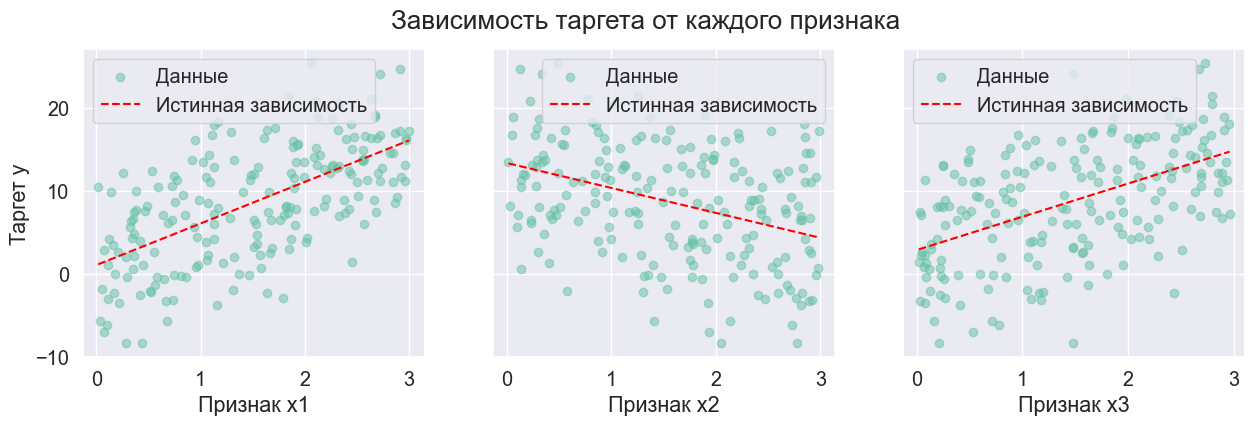

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axes[0].set_ylabel("Таргет y")
for i, ax in enumerate(axes):
    xi = X[:, i]
    ax.scatter(xi, y, alpha=0.5, label="Данные")

    xi_grid = np.linspace(xi.min(), xi.max(), 100)
    xi_true = xi_grid * theta_values[i] + (mean_target - means[i] * theta_values[i])

    ax.plot(xi_grid, xi_true, 'r--', label="Истинная зависимость")
    ax.set_xlabel(f"Признак x{i+1}")
    ax.legend()
plt.suptitle("Зависимость таргета от каждого признака")
plt.show()

Мы понимаем, что строить графики довольно душно, несмотря на их полезность. Вообще главное понимать как их строить, а дальше - можно просить LLM нарисовать красивые графики за вас, если объяснить что именно вы хотите увидеть

#### 1.2 Линейная регрессия

Будем использовать модель линейной регрессии на $d$ признаках:

$$\widehat{y}(x) = \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3,$$

$\theta_i \in \mathbb{R}$ — коэффициент при признаке $ x_i $.

---
Будем использовать <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`LinearRegression`</a>.

>**Важные аргументы конструктора:**
>* `fit_intercept` &mdash; нужно ли включать в модель свободный член. В случае `fit_intercept=True` модели не нужно передавать признак из всех единиц для того, чтобы она оценивала свободный член. По умолчанию `fit_intercept=True`.
>
>**Основные методы класса:**
>* `fit(X, y)` &mdash; обучить линейную регрессию на основе данных `X` предсказывать целевой признак `y`. В данном случае под термином "обучить" поднимается вычисление оценки коэффициентов $\widehat{\theta}$.
>
>* `predict(X)` &mdash; предсказать по данным `X` целевой признак `y`. В данном случае под термином "предсказать" поднимается вычисление оценки целевого признака $\widehat{y}$.
>
>Используем `fit_intercept=True` для оценки свободного коэффициента, что позволяет не добавлять в матрицу признаков столбец из единиц.

---
Напомним, как работают методы `fit` и `predict`:



>`fit`
>
>Делает оценку параметра $\theta$, минимизируя среднеквадратичную ошибку между предсказанными значениями $ \hat{y} $  и истинными значениями $y$:
>
>  $$
  \widehat{\theta} = (X^TX)^{-1}X^Ty
  $$
>
>`predict`
>
>Получает оценку целевого признака по формуле:
>
>$$ \widehat{Y}_{new} = X_{new}\widehat{\theta}$$

---
Теперь попробуем обучить модель линейной регрессии

In [7]:
lr_model = LinearRegression()
lr_model.fit(X, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


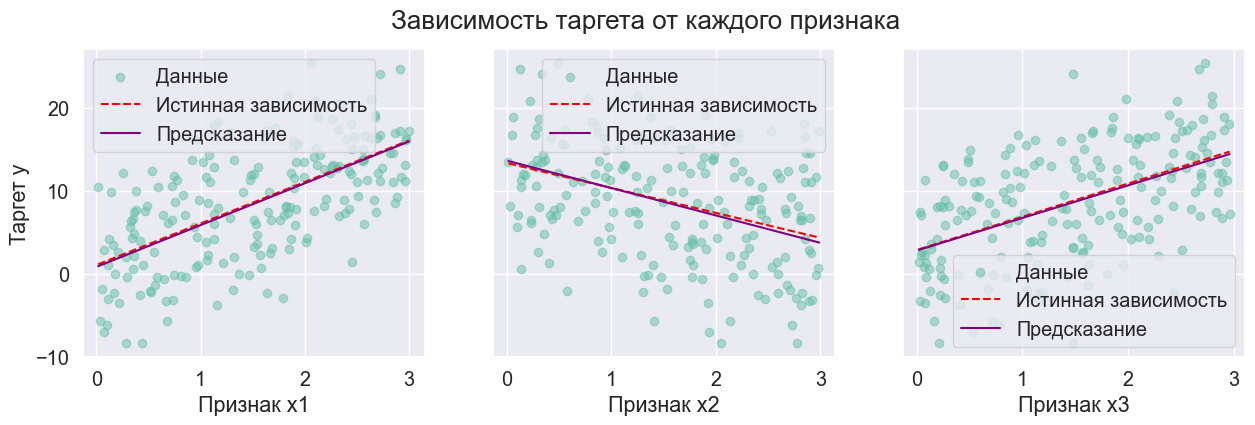

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axes[0].set_ylabel("Таргет y")
for i, ax in enumerate(axes):
    xi = X[:, i]
    ax.scatter(xi, y, alpha=0.5, label="Данные")

    xi_grid = np.linspace(xi.min(), xi.max(), 100)
    xi_true = xi_grid * theta_values[i] + (mean_target - means[i] * theta_values[i])

    ax.plot(xi_grid, xi_true, 'r--', label="Истинная зависимость")

    n_samples = xi_grid.size
    X_test = np.tile(means, (n_samples, 1))
    X_test[:, i] = xi_grid
    y_pred = lr_model.predict(X_test)

    ax.plot(xi_grid, y_pred, '-', label="Предсказание", color="purple")

    ax.set_xlabel(f"Признак x{i+1}")
    ax.legend()
plt.suptitle("Зависимость таргета от каждого признака")
plt.show()

- Линейная регрессия, улавливает тренд, не переобучаясь под шум.
- Почти идеально описывает поведение целевой переменной.
- Предсказание представляет собой линейную комбинацию всех признаков.

---

Посмотрим на значения и коэффициентов и сравним их с значениями из целевой функции. Напомним, что целевая функция
 $$y = 5x_1 - 3x_2 + 4x_3$$
то есть коэффициенты равны `[5, -3, 4]`, а свободный член равен `0`

In [9]:
print(f"Коэффициенты: {lr_model.coef_}")
print(f"Свободный член: {lr_model.intercept_}")

Коэффициенты: [ 5.03532347 -3.29801366  3.92141541]
Свободный член: 0.34738662459952074


Значения очень близки к истинным, небольшое отклонения возникает из-за шума, который мы добавили при генерации. Вопрос, насколько сильно будет отличаться предсказанное значение или коэффициенты от истинных значений, изучается отдельной наукой - статистикой и тоже очень интересен, но сейчас мы рассматривать его не будем

### 2. Нелинейные данные

Теперь посмотрим на работу линейной регрессии на примере с нелинейными зависимостями. Данные описываются зависимостью  $y = f(x) + \varepsilon$, где

* $ f(x) = 3x + 4\sin{x} $ — истинная целевая функция.
* $\varepsilon$ — аддитивный шум, следующий нормальному распределению $\varepsilon \sim \mathcal{N}(0, 1)$.


В контексте этой задачи, ключевой момент будет заключаться в изучении, насколько линейная регрессия может приблизить этот вид нелинейной зависимости.

In [10]:
def generate_linear_data(
    n_samples: int = 100, theta1: float = 3.0, theta2: float = 4.0, X_max: float = 10.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные для линейной модели
    y = features * theta1 + sin(features) * theta2 + ε, где ε ~ N(0, 2).

    Параметры:
    n_samples (int): Количество выборок (по умолчанию 100).
    theta1 (float): Коэффициент для линейной зависимости (по умолчанию 3.0).
    theta2 (float): Коэффициент для зависимости от синуса features (по умолчанию 4.0).
    X_max (float): Максимальное значение для генерации features (по умолчанию 10.0).

    Возвращает:
    Tuple[np.ndarray, np.ndarray]: Кортеж из двух массивов numpy: features и target_values.
    """
    # Признаки: генерация случайных значений от 0 до X_max
    features = np.random.uniform(low=0.0, high=1.0, size=(n_samples, 1)) * X_max
    # Генерация шума
    noise = np.random.normal(loc=0.0, scale=2.0, size=(n_samples, 1))

    # Вычисление target согласно функции
    target_values = features * theta1 + np.sin(features) * theta2 + noise

    return features, target_values

In [11]:
n_samples = 70  # количество элементов в выборке
theta1 = 3  # коэффициент для линейной зависимости
theta2 = 4  # коэффициент при sin(x)
X_max = 3  # максимальное значение X

X_grid = np.linspace(0, X_max, n_samples)  # равномерная сетка для X от 0 до X_max
X, y = generate_linear_data(n_samples=n_samples, theta1=theta1, theta2=theta2, X_max=X_max)

X_grid = X_grid.reshape(-1, 1) #X_grid dimension: (n_samples) -> (n_samples, 1)

Визуализируем данные и истинную зависимость $$f(x) = 3x + 4\sin{x}$$

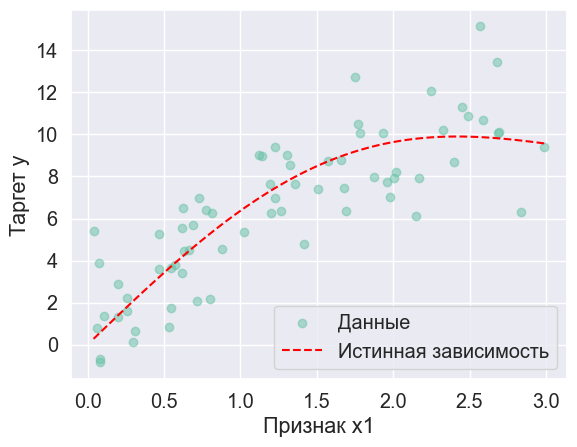

In [12]:
x1 = X[:, 0] 
plt.scatter(x1, y, alpha=0.5, label="Данные")

x1_grid = np.linspace(x1.min(), x1.max(), 100)
# варьируем x1, считаем y
y_true = x1_grid * theta1 + np.sin(x1_grid) * theta2

plt.plot(x1_grid, y_true, 'r--', label="Истинная зависимость")
plt.xlabel("Признак x1")
plt.ylabel("Таргет y")
plt.legend()
plt.show()

#### 2.1 Модель

Попробуем предсказать значение $y$ по значению $x$, обучив для начала модель линейной регрессии по признаку $X_1 = x$.
Множество модель линейной регрессии в данном случае имеет вид:
$$
\widehat{y}(x) = \theta_0 + \theta_1 x,
$$
где:
- $ \theta_0 \in \mathbb{R} $ — свободный член (intercept),
- $ \theta_1 \in \mathbb{R} $ — коэффициент при признаке $ x $.

Модель предполагает, что зависимость между $ x $ и $ y $ линейна. В нашей задаче истинная зависимость нелинейная, поэтому модель линейной регрессии может не дать хорошего приближения.


Обучаем модель линейной регрессии на данных, используя только один признак $ x $.


In [13]:
model = LinearRegression()  # объявляем модель
model.fit(X, y)  # обучаем на признаке x

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Оценки свободного коэффициента $\theta_0$ и коэффициента $\theta_1$ при $x$

In [14]:
model.intercept_, model.coef_

(array([1.98630985]), array([[3.49051657]]))

Сравним предсказания модели с истинной зависимостью.


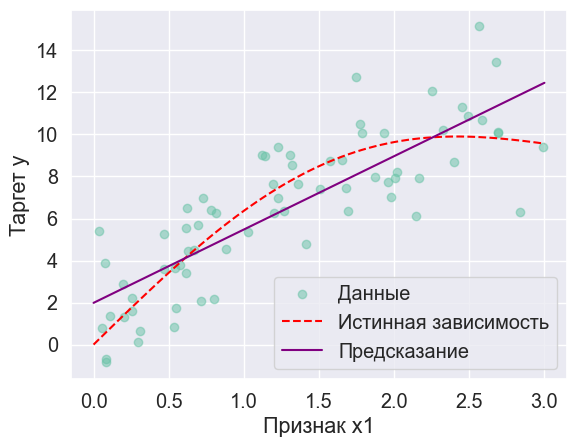

In [15]:
x1 = X[:, 0] 
plt.scatter(x1, y, alpha=0.5, label="Данные")

# варьируем x1, считаем y
y_true = X_grid * theta1 + np.sin(X_grid) * theta2
y_pred = model.predict(X_grid) 

plt.plot(X_grid, y_true, 'r--', label="Истинная зависимость")
plt.plot(X_grid, y_pred, '-', label="Предсказание", color="purple")

plt.xlabel("Признак x1")
plt.ylabel("Таргет y")
plt.legend()
plt.show()

&#x2753; **Вопрос** &#x2753;

> Что можно сделать для повышения точности предсказаний?

<details>
  <summary> Кликни для показа ответа </summary>
  
> 1. **Усложнить модель**.
> Если текущая модель (например, линейная регрессия) недостаточно хорошо учитывает сложные зависимости в данных, можно перейти на более сложные модели, которые способны учитывать нелинейные зависимости и взаимосвязи между признаками.
>
>
>
> 2. **Добавить новые признаки.**
>
>     Примеры преобразований:
>       * Из временн*ы*х данных можно извлечь день недели, месяц, год или временн*ы*е интервалы.
>
>       * Полиномиальные признаки. Добавление квадратов, кубов или произведений существующих признаков может помочь модели уловить нелинейные зависимости.
>
>       * Создание новых признаков как комбинаций существующих (например, умножение или деление двух признаков).
>
>       * Группировка числовых признаков в интервалы (например, возрастные группы).
>
>       * Кодирование категориальных признаков. Использование One-Hot Encoding для преобразования категориальных данных в числовые.
>
> Далее рассмотрим второй вариант.
</details><br/>

---
#### 2.2 Модель с нелинейными признаками

Видим, что исходная зависимость не является линейной, а предсказания модели линейны по $x$, поэтому такая модель может быть не очень хорошей для наших данных. Попробуем добавить нелинейные признаки и сделать предсказания с их использованием.

Одно нелинейных преобразований &mdash; полиномиальное преобразование (в данном случае попробуем использовать признак $x^2$). Добавим $x^2$ в матрицу признаков.

In [16]:
model_2 = LinearRegression()  # объявляем модель

data = pd.DataFrame(
    {"X": X.flatten(), "X^2": X.flatten() ** 2}
)  # создаем новый датасет с использованием X^2

data.head()

,X,X^2
0,0.256049,0.065561
1,2.990623,8.943824
2,1.506585,2.269798
3,1.786155,3.190350
4,0.201229,0.040493


&#x2753; **Вопрос** &#x2753;

> Какой вид будет иметь модель линейной регрессии при добавлении нового признака?

<details>
  <summary> Кликни для показа ответа </summary>
  
> $$
\widehat{y}(x) = \theta_0 + \theta_1 x + \theta_2 x^2,
$$
> - $ \theta_0 \in \mathbb{R} $ — свободный член (intercept),
> - $ \theta_1$, $\theta_2 \in \mathbb{R} $ — коэффициенты при $ x $ и $x^2$.
</details><br/>



In [17]:
model_2.fit(data, y)  # обучим модель на новых данных

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Посмотрим, какие предсказания выдает модель, обученная на полиномиальных признаках.

/Users/mariia/VSCodeProjects/sirius-linreg/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


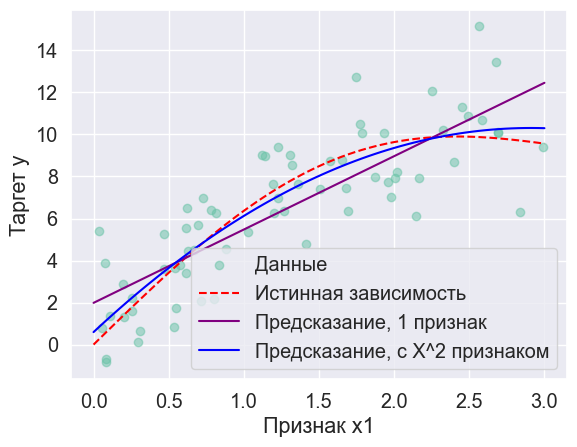

In [18]:
x1 = X[:, 0] 
plt.scatter(x1, y, alpha=0.5, label="Данные")

# варьируем x1, считаем y
y_true = X_grid * theta1 + np.sin(X_grid) * theta2
y_pred = model.predict(X_grid)

X_grid_2 = np.concat([X_grid, X_grid ** 2], axis=1)
y_pred_2 = model_2.predict(X_grid_2) 

plt.plot(X_grid, y_true, 'r--', label="Истинная зависимость")
plt.plot(X_grid, y_pred, '-', label="Предсказание, 1 признак", color="purple")
plt.plot(X_grid, y_pred_2, '-', label="Предсказание, с X^2 признаком", color="blue")


plt.xlabel("Признак x1")
plt.ylabel("Таргет y")
plt.legend()
plt.show()

По графику видно, что модель, обученная с добавлением признака, лучше приближает исходную зависимость.

**Результаты**
1. Линейная регрессия с одним признаком $ x $ не способна хорошо аппроксимировать нелинейную зависимость.
2. Добавление полиномиального признака $ x^2 $ улучшает качество модели, но всё равно не позволяет точно описать истинную зависимость $ f(x) = 3x + 4\sin{x} $.
3. Для более точного описания данных можно рассмотреть другие нелинейные признаки (например, $ \sin{x} $) или использовать более сложные модели.

### 3. Постановка задачи на реальных данных

Рассмотрим данные медицинского страхования. В каждой строке представлены признаки для каждого клиента страховой организации.

В данных содержатся следующие признаки:
* `age` &mdash; день рождения;
* `sex` &mdash; пол, возможные значения: `female`, `male`;
* `bmi`  &mdash; соотношение массы тела квадрату его высоты (body mass index), измеряется в кг/м$^2$, хорошие значения лежат в диапазоне от 18.5 до 24.9;
* `children` &mdash; количество детей;
* `smoker` &mdash; курит ли клиент;
* `region` &mdash; район в США, возможные значения: `northeast`, `southeast`, `southwest`, `northwest`;
* `charges` &mdash; индивидуальные медицинские расходы, оплачиваемые медицинским страхованием.

**Задача:** предсказать *индивидуальные медицинские расходы* по остальным признакам.\
\
Это может быть полезно для таких целей:
  
- **Определение оптимальных взносов:** На основании предсказанных медицинских расходов компании могут устанавливать размер страховых взносов таким образом, чтобы они покрывали ожидаемые траты.
- **Оптимизация страховок:** Определять, какие группы населения более подвержены высоким расходам, и разрабатывать продукты и тарифы, которые лучше обслуживают эти сегменты рынка.
- **Осведомленность и планирование:** Пациенты могут использовать информацию, чтобы понять, как их образ жизни и личные характеристики могут влиять на будущие медицинские расходы, и предпринять шаги по их снижению, например, прекращение курения или поддержание здорового веса.




Оригинальные данные можно посмотреть на <a target="_blank" href="https://www.kaggle.com/mirichoi0218/insurance">Kaggle</a>.

Загрузим данные

In [2]:
data = pd.read_csv("./insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Посмотрим на размер таблицы

In [3]:
data.shape

(1338, 7)

Тестировать качество построенной модели всегда нужно на данных, которые не участвовали в обучении. Такие данные называются *тестовыми*. Данные, которые участвуют в обучении, называются *обучающими*.

Выполнить **разбиение на обучающие и тестовые данные** можно с помощью функции <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`train_test_split`</a>.
Применим эту функцию к нашим данным, отнеся в тестовую часть 20% данных, а в обучающую &mdash; остальные 80%.

In [4]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train.shape, test.shape

((1070, 7), (268, 7))

In [5]:
train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Посмотрим на графики зависимости таргета от признаков

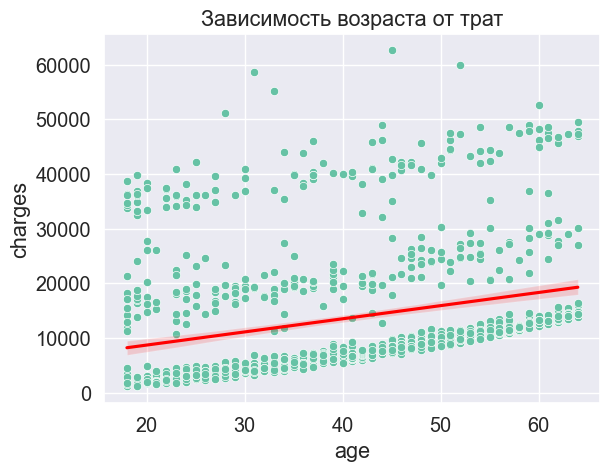

In [6]:
sns.scatterplot(x='age', y='charges', data=train)
sns.regplot(
    x='age',
    y='charges',
    data=train,
    scatter=False,
    color='red'
)
plt.title('Зависимость возраста от трат')
plt.show()

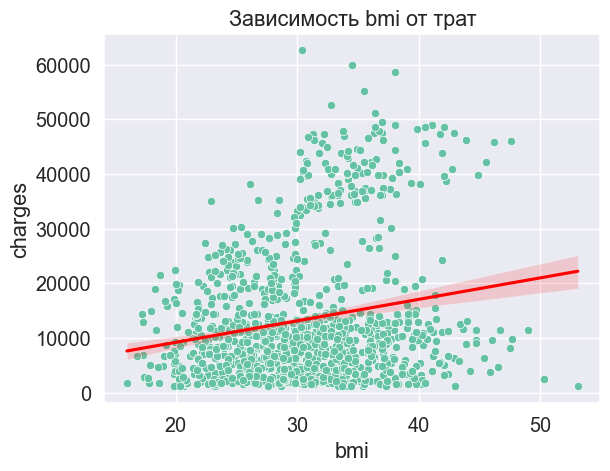

In [7]:
sns.scatterplot(x='bmi', y='charges', data=train)
sns.regplot(
    x='bmi',
    y='charges',
    data=train,
    scatter=False,
    color='red'
)
plt.title('Зависимость bmi от трат')
plt.show()

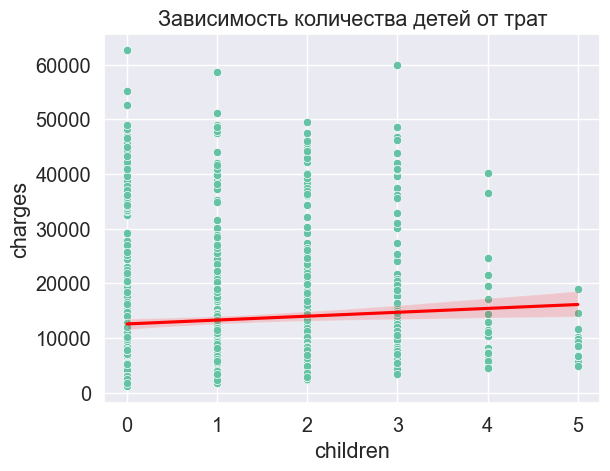

In [8]:
sns.scatterplot(x='children', y='charges', data=train)
sns.regplot(
    x='children',
    y='charges',
    data=train,
    scatter=False,
    color='red'
)
plt.title('Зависимость количества детей от трат')
plt.show()

Выделим группы признаков

In [9]:
categorial_features = ["sex", "smoker", "region"]  # категориальные признаки
real_features = ["age", "bmi", "children"]  # вещественные признаки
target_feature = "charges"  # целевой признак

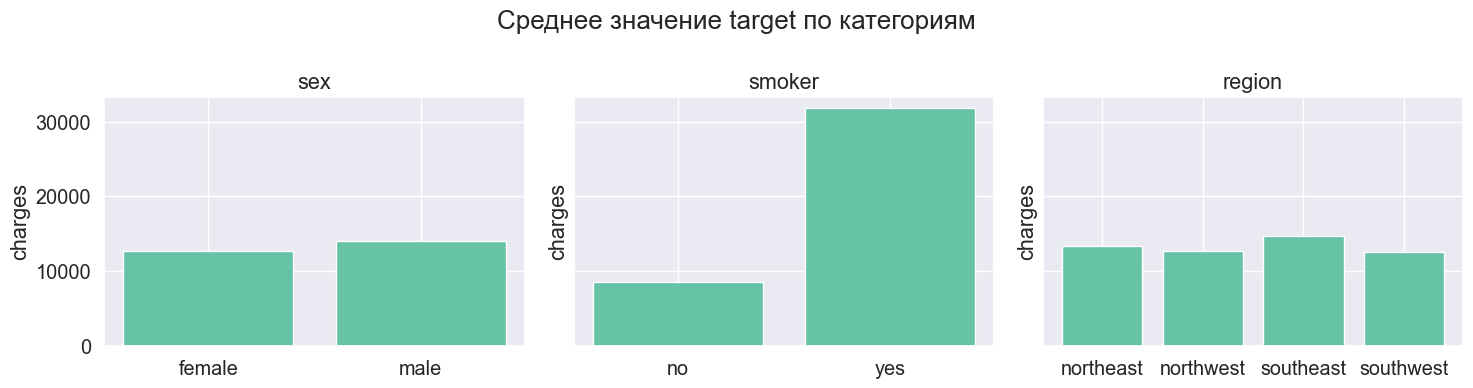

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, feature in zip(axes, categorial_features):
    means = train.groupby(feature)[target_feature].mean()
    ax.bar(means.index, means.values)
    ax.set_title(feature)
    ax.set_xlabel("")
    ax.set_ylabel(target_feature)

plt.suptitle("Среднее значение target по категориям")
plt.tight_layout()
plt.show()


По графикам сразу можно сделать следующие выводы:
* расходы растут с увеличением возраста клиента;
* величина расходов больше для курящих людей.

Видимо, эти признаки должны оказать существенное влияние при построении регрессионной модели.

Рассмотрим матрицу корреляции признаков

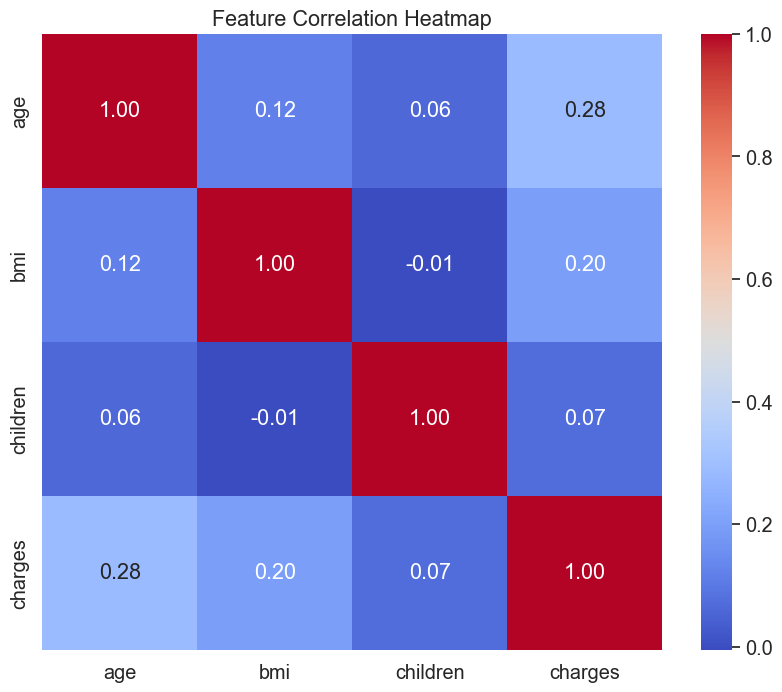

,age,bmi,children,charges
age,1.000000,0.118274,0.060999,0.281721
bmi,0.118274,1.000000,-0.005040,0.197316
children,0.060999,-0.005040,1.000000,0.071885
charges,0.281721,0.197316,0.071885,1.000000


In [11]:
corr = train.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
corr

---
Напомним, как работают методы `fit` и `predict`:



>`fit`
>
>Делает оценку параметра $\theta$, минимизируя среднеквадратичную ошибку между предсказанными значениями $ \hat{y} $  и истинными значениями $y$:
>
>  $$
  \widehat{\theta} = (X^TX)^{-1}X^Ty
  $$
>
>`predict`
>
>Получает оценку целевого признака по формуле:
>
>$$ \widehat{Y}_{new} = X_{new}\widehat{\theta}$$

---
Теперь попробуем обучить модель линейной регрессии, используя различные наборы признаков

In [28]:
y_train = train[target_feature]
y_test = test[target_feature]

#### 3.1 Примеры с использованием одно признака

In [29]:
X_train = train["age"].to_numpy().reshape(-1, 1)
X_test = test["age"].to_numpy().reshape(-1, 1)

**Признак `age`**

In [30]:
model_age = LinearRegression()  # объявляем модель
model_age.fit(X_train, y_train)  # обучаем на признаке age

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Получим предсказание модели для тестовых и обучающих данных

In [31]:
y_train_pred = model_age.predict(X_train)
y_test_pred = model_age.predict(X_test)

Строим график

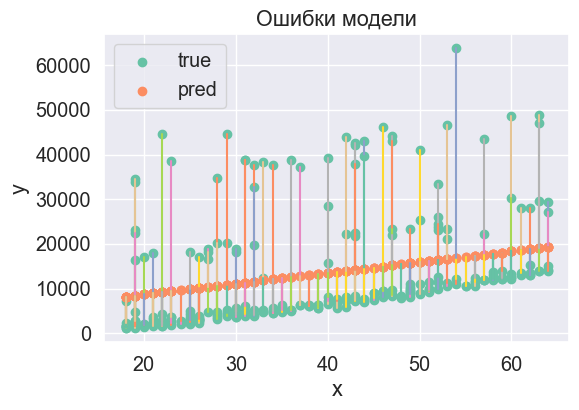

In [32]:
plt.figure(figsize=(6, 4))

plt.scatter(X_test, y_test, label="true")
plt.scatter(X_test, y_test_pred, label="pred")

for x, yt, yp in zip(X_test, y_test, y_test_pred):
    plt.plot([x, x], [yt, yp])

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Ошибки модели")
plt.show()


На этом графике палочки - это ошибки модели, чем длиннее палочка, тем сильнее модель ошиблась. В целом, модель уловила тренд, но оказалсь сдвинута вверх из-за небольшого количества высоких значений таргета.

А пока запишем метрики данной модели, подробнее про них - далее

In [33]:
results_test = []
results_train = []
results_test.append({
    "model": "age",
    "rmse": metrics.root_mean_squared_error(y_test, y_test_pred),
    "r2": metrics.r2_score(y_test, y_test_pred),
})
results_train.append({
    "model": "age",
    "rmse": metrics.root_mean_squared_error(y_train, y_train_pred),
    "r2": metrics.r2_score(y_train, y_train_pred)
})

---
#### 3.2 Обработка категориальных признаков

Далее **закодируем категориальные признаки** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">`OneHotEncoder`</a>. Напомним, данный метод из одного категориального признака делает несколько бинарных признаков по количеству различных значений исходного категориального признака. Например, если исходный признак принимал 5 различных значений, то его кодировкой будет 5 новых бинарных признаков, где единица будет только у того бинарного признака, который соответствует данному значению исходного категориального признака. Иногда, *например, для линейной регрессии*, необходимо делать на один бинарный признак *меньше*, поскольку значения оставшегося бинарного признака можно выразить из значений всех остальных бинарных признаков.

>**Важные аргументы конструктора:**
>* `categories` &mdash; если установлено значение `auto`, то категории определяются по имеющемуся объему данных, иначе, используется список категорий, который передается этим аргументом.
* `drop` &mdash; указывает методику, используемую для удаления одной из категорий для каждого объекта. Это может быть полезно для некоторых моделей, например, для линейной регрессии. Возможные значения указаны далее.
  * `None` &mdash; оставляем все признаки.
  * `'first'` &mdash; удаляет первую категорию для каждого признака. Если признак имеет одну категорию, то он будет удален полностью.
  * `'if_binary'` &mdash; удаляет первую категорию только для бинарных признаков.
  * массив`drop`, где `drop[i]` &mdash; категория в признаке feature `X[:, i]`, которая должна быть удалена.
* `sparse_output` &mdash; возвращает sparse-матрицу, если установлено значение `True`, иначе &mdash; массив.
>
>**Основные методы класса:**
* `fit(X)` &mdash; обучить кодировщик кодировать признаки на основе данных `X`. В данном случае под термином "обучить" поднимается определение функций кодирования и декодирования признаков.
* `transform(X)` &mdash; закодировать признаки в данных `X`.
* `fit_transform(X)` &mdash; обучить кодировщик по данным `X` и сразу их закодировать.
* `inverse_transform(X)` &mdash; декодировать признаки в данных `X`, то есть перевести бинарные признаки в исходные категориальные.

---

При построении кодировщика для наших данных учтем ряд особенностей:
* указываем `drop='first'`, то есть одну категорию нужно исключить;
* указываем `sparse_output=False`, то есть вернуть нужно неразреженную матрицу;
* нужно выполнить *обучение*, что в данном случае подразумевает построение и сохранение правила преобразования;
* сразу же кодируем признаки из обучающего множества;

In [34]:
encoder = OneHotEncoder(drop="first", sparse_output=False)  # объявляем модель

# Внимание! Нельзя вызывать fit_transform на тестовых данных!
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.]], shape=(1070, 5))

#### 3.3 Обучение на всех признаках

Соединим вместе вещественные признаки и закодированные категориальные

In [35]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

Обучим модель, используя категориальные и вещественные признаки

In [36]:
model_full = LinearRegression()
model_full.fit(X_train, train[target_feature])

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [37]:
model_full.coef_

array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02, -1.85916916e+01,
        2.36511289e+04, -3.70677326e+02, -6.57864297e+02, -8.09799354e+02])

Оценка свободного коэффициента

In [38]:
model_full.intercept_

np.float64(-11931.219050326688)

### 4. Тестирование и оценка качества

Пусть мы обучили конкретную модель и можем получать предсказания таргета. Для оценки качества полученных предсказаний можно использовать различные функционалы ошибки и функционалы качества. Далее рассмотрим некоторые из них

In [39]:
# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним *предсказания* построенными ранее моделями с помощью метода `predict`

In [40]:
y_train_pred = model_full.predict(X_train)
y_test_pred = model_full.predict(X_test)

>**Напоминание:** наиболее популярный способ посчитать ошибку предсказания &mdash; **метрика MSE** (*mean squared error*). Пусть $Y_1, ..., Y_n$ &mdash; истинные значения, а $\widehat{Y}_1, ..., \widehat{Y}_n$ &mdash; предсказания. Тогда метрика MSE определяется как
$$MSE = \frac{1}{n}\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2.$$

Метрика MSE сама по себе плохо интерпретируема в исходных единицах. Её основное применение — оптимизация и сравнение моделей, а не использование в отчётности.

Посчитаем ее, а точнее &mdash; корень из нее, который еще обозначается как RMSE (*root MSE*)

In [41]:
np.sqrt(((y_test - y_test_pred) ** 2).mean())

np.float64(5796.2846592762735)

Это значение уже имеет конкретный смысл  &mdash; насколько в среднем модель отклоняется от истинного значения. То есть в среднем отклонения предсказания величины страховых расходов имеют порядок 6 000 условных единиц. Напомним, что в данных страховые расходы в основной массе принимают значения до 50 000 у.е..

Готовая <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">реализация</a> также есть в `sklearn`:

In [42]:
metrics.mean_squared_error(y_test, y_test_pred) ** 0.5

5796.2846592762735

---
>Еще для измерения качества модели можно использовать **коэффициент детерминации $ R^2 $**, который также часто используется для оценки качества предсказательной модели. Этот коэффициент измеряет, какую долю дисперсии зависимой переменной модель сумела объяснить.
>
>Коэффициент детерминации $R^2$ рассчитывается как:
>$$
R^2 = 1 - \frac{\sum\limits_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2}{\sum\limits_{i=1}^n \left(Y_i - \overline{Y}\right)^2},
$$
>где
> - $\sum\limits_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2$ — сумма квадратов ошибок (SSE),
> - $\overline{Y} = \frac{1}{n} \sum\limits_{i=1}^n Y_i$ — среднее из всех истинных значений,
> - $\sum\limits_{i=1}^n \left(Y_i - \overline{Y}\right)^2$ — полная сумма квадратов (SST).

&#x2753; **Вопрос** &#x2753;

Чему равно значение метрики $R^2$ для "идеальной модели"?

<details>
<summary> Кликни для показа ответа </summary>
  
> $R^2 = 1$
>
> Интерпретация $R^2$
> - $R^2 = 1$: Такая модель объясняет всю дисперсию данных (идеальный случай).
> - $R^2 = 0$: Модель не объясняет дисперсию данных лучше, чем просто среднее значение $Y$.
> - $R^2 < 0$: Модель объясняет дисперсию хуже, чем простая модель без регрессии (может случиться, если модель переобучается или плохо подходит для использования на конкретных данных).

</details><br/>





Для сравнения посчитаем предсказания и ошибки на обучающем и тестовом множествах.

In [43]:
results_test.append({
    "model": "all features",
    "rmse": metrics.root_mean_squared_error(y_test, y_test_pred),
    "r2": metrics.r2_score(y_test, y_test_pred),
})
results_train.append({
    "model": "all features",
    "rmse": metrics.root_mean_squared_error(y_train, y_train_pred),
    "r2": metrics.r2_score(y_train, y_train_pred)
})

Метрики для тестовой выборки

In [44]:
pd.DataFrame(results_test)

,model,rmse,r2
0,age,11661.215952,0.124090
1,all features,5796.284659,0.783593


Метрики для обучающей выборки

In [45]:
pd.DataFrame(results_train)

,model,rmse,r2
0,age,11527.28721,0.079367
1,all features,6105.54516,0.741726


- $MSE$ используется как техническая метрика для оптимизации моделей
- Для сравнения моделей между собой полезно использовать $R^2$

---
Модель, использующая все признаки имеет более высокое качество, чем модели, обученные на одном или двух признаках.

Мы видим, что на обучающем множестве значения ошибок предсказания получились немного меньше, чем на тестовом множестве. Это и понятно, ведь наша модель так построена по обучающим данным, чтобы давать на них наименьшую ошибку. На данных, которые она "не видела" при обучении, она может вычислять предсказания несколько хуже. В этом и есть причина разделения данных на обучающую и тестовую часть.

Нередко случается так, что на обучающих данных модель ошибается гораздо меньше, чем на тестовых. Такую ситуацию еще называют **переобучением**. Простой пример &mdash; студент, который готовится к экзамену только за пару дней до него исключительно по билетам, не занимаясь при этом по предмету в течении семестра. Он может хорошо ответить по билетам на экзамене, ведь именно по ним он обучился. Однако, опыт показывает, что знания по каким-то другим вопросам оказываются значительно хуже, не говоря уже о применении полученных знаний в реальной практике.

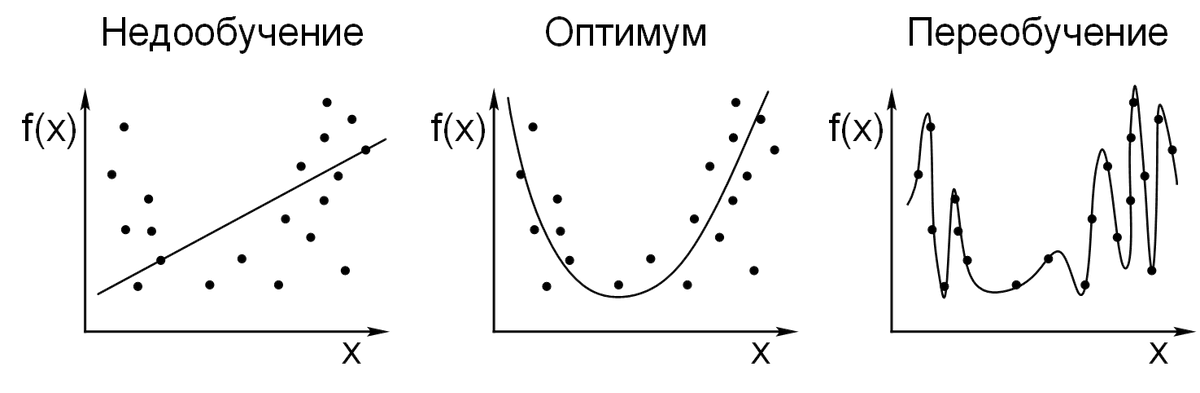

### 5. Попытки улучшить качество

Выше мы могли получить только линейную зависимость от исходных признаков, поэтому может быть полезно добавить преобразования признаков, чтобы в результате модель могла бы предсказывать более сложные зависимости.

Список преобразований, которые могут быть полезны при обучении регрессии:

> 1. **Стандартизация данных**. Пусть $x_{ij}$ &mdash; значение признака $j$ для объекта $i$. Обозначим $m_j$ &mdash; выборочное среднее значение признака $j$ (функция `np.mean`), а $s^2_j$ &mdash; выборочную дисперсию признака $j$ (функция `np.var`). Тогда стандартизацией является преобразование
>    $$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{s_j}.$$
> 2. Добавление нелинейности с помощью **полиномиальных признаков**. Создание новых признаков как полиномиальных комбинаций исходных. Полиномиальная регрессия может улучшить модель, если данные обладают нелинейными взаимозависимостями.
> 3. Логарифмирование
> 4. Обработка выбросов

Попробуем для текущей задачи подобрать нелинейное преобразование, которое поможет улучшить качество предсказания.



Посмотрим еще раз на истинные и предсказанные медицинские расходы в зависимости от признака `smoker`.

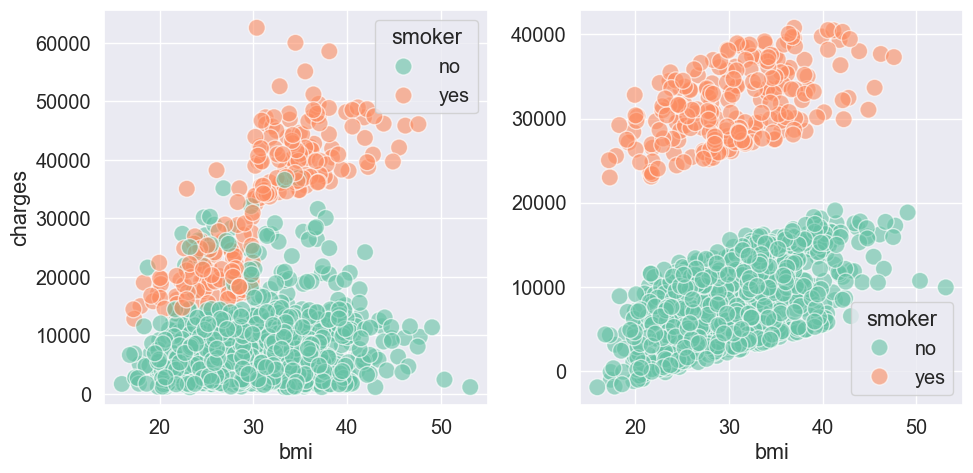

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(ax=axes[0], x=train["bmi"], y=train["charges"], hue=train["smoker"], alpha=0.6, s=150)
ax.set_title("Истинная зависимость")
ax.set_xlabel("BMI")
ax.set_ylabel("charges")

sns.scatterplot(ax=axes[1], x=train["bmi"], y=y_train_pred, hue=train["smoker"], alpha=0.6, s=150)
ax.set_title("Истинная зависимость")
ax.set_xlabel("BMI")
ax.set_ylabel("charges")

plt.tight_layout()
plt.show()

Мы видим, что предсказания `charges` (расходы) увеличиваются на один и тот же коэффициент при росте `bmi` (индекса массы тела) на 1 как для `smoker = "yes"` (курящие), так и для `smoker = "no"` (некурящие).

В то же время по графику реальных данных, то можно заметить, что зависимость расходов от `bmi` отличается в зависимости от признака `smoker`. Есть предположение, что после добавления признака `[smoker * bmi]` предсказания для объектов со значением `smoker = "yes"` улучшатся.


In [47]:
# для обучающей выборки
train["smoker_bmi"] = (train["smoker"] == "yes") * train["bmi"]

# для тестовой выборки
test["smoker_bmi"] = (test["smoker"] == "yes") * test["bmi"]

real_features.extend(["smoker_bmi"])

Обучим модель с новыми признаками

In [48]:
X_train = np.hstack([train[real_features], train_cat])
X_test = np.hstack([test[real_features], test_cat])

model_with_new_feature = LinearRegression()
model_with_new_feature.fit(X_train, y_train)

y_new_train_pred = model_with_new_feature.predict(X_train)
y_new_test_pred = model_with_new_feature.predict(X_test)

# добавим метрики
results_test.append({
    "model": "new feature",
    "rmse": metrics.root_mean_squared_error(y_test, y_new_test_pred),
    "r2": metrics.r2_score(y_test, y_new_test_pred),
})
results_train.append({
    "model": "new feature",
    "rmse": metrics.root_mean_squared_error(y_train, y_new_train_pred),
    "r2": metrics.r2_score(y_train, y_new_train_pred)
})

Посмотрим на предсказания модели с новым признаком.

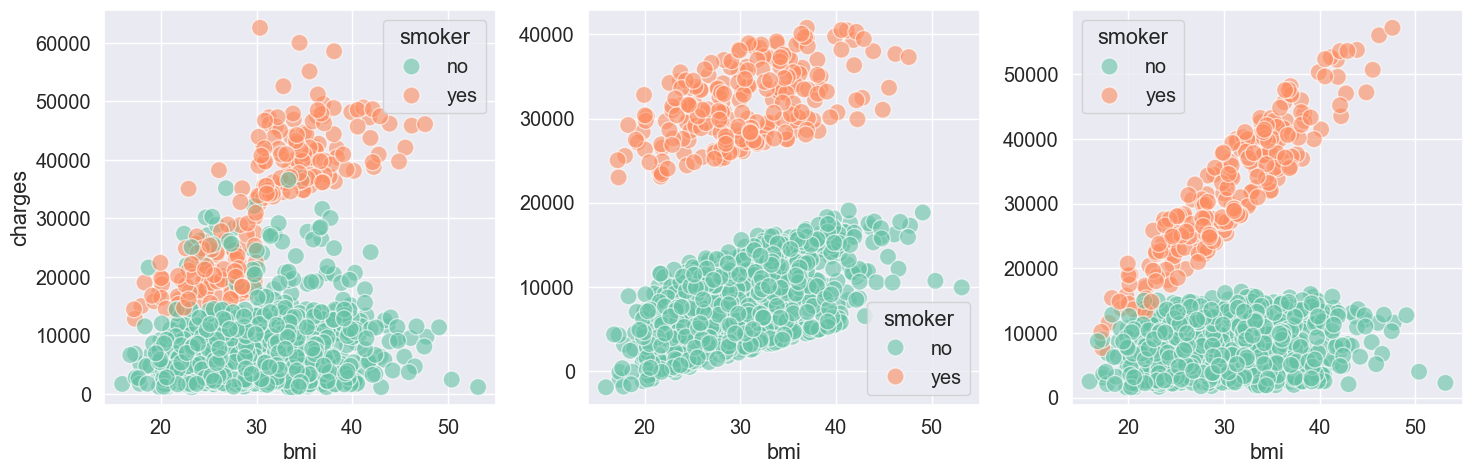

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(ax=axes[0], x=train["bmi"], y=train["charges"], hue=train["smoker"], alpha=0.6, s=150)
ax.set_title("Истинная зависимость")
ax.set_xlabel("BMI")
ax.set_ylabel("charges")

sns.scatterplot(ax=axes[1], x=train["bmi"], y=y_train_pred, hue=train["smoker"], alpha=0.6, s=150)
ax.set_title("Истинная зависимость")
ax.set_xlabel("BMI")
ax.set_ylabel("charges")

sns.scatterplot(ax=axes[2], x=train["bmi"], y=y_new_train_pred, hue=train["smoker"], alpha=0.6, s=150)
ax.set_title("Истинная зависимость")
ax.set_xlabel("BMI")
ax.set_ylabel("charges")

plt.tight_layout()
plt.show()

Теперь можно увидеть, что при увеличении bmi на 1, charges меняется на значение, которое зависит от признака smoker, т.е. модель учла эту зависимость.

Получим метрики на тестовой выборке

In [50]:
pd.DataFrame(results_test)

,model,rmse,r2
0,age,11661.215952,0.124090
1,all features,5796.284659,0.783593
2,new feature,4573.807686,0.865250


Значение ошибок значительно уменьшилось, с добавлением нового признака получилось повысить качество предсказаний!

Порой линейных моделей недостаточно для точных предсказаний, поэтому появляется необходимость в использовании более сложных моделей и нелинейных зависимостей.

### 6. Интерпретация результатов

> Существует область машинного обучения Explainable AI (XAI), которая занимается тем, что пытается разными способами понять, как работает модель, на какие признаки обращает внимание, насколько является устойчивой... То есть пытается интерпретировать работу модели. Это очень актуальная задача, поскольку таким образом мы можем:
> - узнавать новую информацию о наших данных;
> - понимать, умеет ли модель обращать внимание на действительно важные признаки;
> - находить слабости модели;
> - валидировать ее работу и т. д.
>
> Сам подход имеет широкое распространение в сфере бизнеса, поскольку модели, используемые для принятия важных
решений, таких как постановка медицинского диагноза, решение о выдаче кредита, беспилотное управление транспортом и т.п., должны соответствовать ГОСТ 59276-2020, регулирующему доверие к ИИ и объяснимость их результатов. Однако не меньший интерес область вызывает и в науке, например, чтобы понимать важность разных генов для формирования фенотипа и формулировать новые гипотезы.

---
В линейной регрессии коэффициенты характеризуют величину и направление влияния каждого признака на целевую переменную. Однако интерпретация коэффициентов может быть затруднена, если признаки имеют разные единицы измерения или разный диапазон значений, так коэффициенты могут быть соответственно несоизмеримы по величине. Например, изменения в высоте в миллиметрах окажут меньшее влияние на предсказания, чем изменения в метрах, если использовать те же коэффициенты.
Для стандартизации будем использовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

>`fit(X)`\
>Метод fit используется для вычисления основных статистик, таких как среднее значение и стандартное отклонение, для каждого признака на предоставленных данных `X`. Эти статистики затем используются для стандартизации признаков.
>
>`transform(X)`:\
>После вычисления статистик с помощью `fit`, метод `transform` применяется для преобразования данных `X`. Он вычитает среднее и делит на стандартное отклонение для каждого признака.
>`fit_transform(X)`:
>Назначение: Этот метод сочетает в себе `fit` и `transform` в одной операции.




Важно помнить, что необходимо выполнять `fit` или `fit_transform` только на тренировочных данных, так как возможна утечка информации из тестового набора данных в тренировочный. Если вы выполните fit на всех данных сразу, то модель может получить дополнительную информацию о тестовых данных, что может помешать объективной оценке качества.


---
Обучим модель после стандартизации данных

In [51]:
# Инициализация и применение StandardScaler
scaler = StandardScaler()
# Внимание! Нельзя вызывать fit_transform на тестовых данных!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели линейной регрессии
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Посмотрим на значения ошибок и коэффициенты в последней линейной модели и сделаем выводы.

In [52]:
# Коэффициенты модели
coefficients = model_scaled.coef_

# Признаки
encoded_features = encoder.get_feature_names_out()
feature_names = real_features + list(encoded_features)

coef_df = pd.DataFrame({"Признак": feature_names, "Значение коэффициента": coefficients})
coef_df

,Признак,Значение коэффициента
0,age,3705.216463
1,bmi,122.326119
2,children,563.530391
3,smoker_bmi,18608.731140
4,sex_male,-262.537886
5,smoker_yes,-8570.662519
6,region_northwest,-269.379329
7,region_southeast,-426.716078
8,region_southwest,-531.739530


Визуализируем полученные полученные коэффициенты

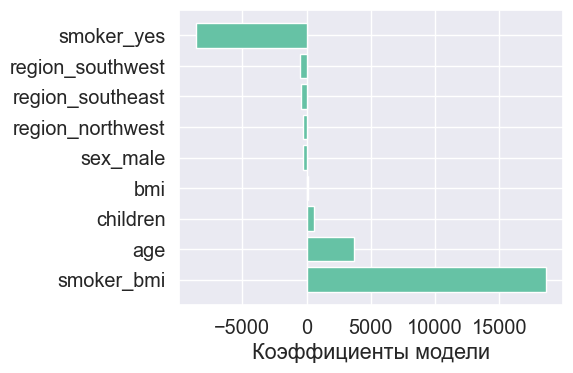

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(6, 4), tight_layout=True)

df_sorted = coef_df.sort_values(by="Значение коэффициента", ascending=False)

ax.barh(df_sorted["Признак"], df_sorted["Значение коэффициента"])
ax.set_xlabel("Коэффициенты модели")
plt.show()

&#x2753; **Вопрос** &#x2753;

> Какие выводы можно сделать на основе полученных коэффициентов?

<details>
  <summary> Кликни для показа ответа </summary>
  
> **Коэффициенты регрессии**
>
> 1. Возраст (`age`): Коэффициент 3707.57 предполагает, что с увеличением возраста на 1 год, при прочих равных, ожидается увеличение предполагаемых затрат на 3707.57. Это указывает на то, что возраст является существенным фактором.
>
> 2. Произведение курильщика и индекса массы тела (`smoker_bmi`): Высокий коэффициент 18612.94 указывает на сильный положительный эффект. Это может означать, что взаимодействие между курением и `bmi` оказывает значительное влияние на целевую переменную.




</details><br/>





---

Несмотря на улучшение метрик предсказательной способности, важно понимать, что подобные интерпретации всегда нуждаются в подтверждении на большем количестве данных и более детальной проверке каждой гипотезы. В данном случае добавление нового признака привело к увеличению качества предсказаний, поэтому при подборе новых признаков бывает полезно учитывать природу данных, но в случае, когда зависимости более сложные, имеет смысл рассматривать другие модели.



---
LLM в математике и информатике, Сириус, по мотивам курса ML-1 ШАД от команды ThetaHat